# Fractional Cover Prediction in Tensorflow
## Setup the training data

In [31]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import datetime
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
import tensorflow as tf
import numpy as np

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.constraints import max_norm

from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch


#import tensorboard
print("TensorFlow v"+tf.__version__)
#print("Tensorboard v"+tensorboard.__version__)

print(tf.test.gpu_device_name())


raw_dataset = pd.read_csv('fcData.csv',
                        na_values = "nan",
                        sep=",",
                        skipinitialspace=True)

dataset = raw_dataset.copy()
dataset = dataset.apply(pd.to_numeric, errors='coerce')



# Make a copy
dataset = raw_dataset.copy()

# Not required felds. Note that Crypto is already merged into the appropriate dry or green fraction
[dataset.pop(x) for x in ['crypto','pg','pnpv']]
# Adding in these makes no difference to the model so they're dropped
[dataset.pop(x) for x in ['burn','ndvi','ndwi']]
#[dataset.pop(x) for x in ['burn','ndwi']]
# Dropping out the SWIR to test
#[dataset.pop(x) for x in ['b5','b7']]

full_dataset = dataset.copy()
print(full_dataset.shape)
full_labels = pd.concat([full_dataset.pop(x) for x in ['bare','pv','npv']], 1)


# Get a training Subset
train_dataset = dataset.sample(frac=1.0)
print(train_dataset.shape)


train_stats = train_dataset.describe()
[train_stats.pop(x) for x in ['bare','pv','npv']]
train_stats = train_stats.transpose()

train_labels = pd.concat([train_dataset.pop(x) for x in ['bare','pv','npv']], 1)


test_dataset = dataset.drop(train_dataset.index)
print(test_dataset.shape)
test_labels = pd.concat([test_dataset.pop(x) for x in ['bare','pv','npv']], 1)


# Some Stats
print(train_stats)
# Pretty Plot
#sns.pairplot(dataset, diag_kind="kde")



TensorFlow v2.0.0
/device:GPU:0
(3945, 8)
(3945, 8)
(0, 8)
     count      mean       std       min       25%       50%       75%  \
b2  3945.0  0.099050  0.037294  0.007989  0.076267  0.097625  0.119078   
b3  3945.0  0.145600  0.059471  0.008811  0.106089  0.146489  0.185206   
b4  3945.0  0.241857  0.052786  0.034624  0.205800  0.239022  0.275471   
b5  3945.0  0.306296  0.083756  0.016078  0.261760  0.311936  0.361433   
b7  3945.0  0.230864  0.087335  0.005978  0.178533  0.229589  0.288533   

         max  
b2  0.520130  
b3  0.545005  
b4  0.559841  
b5  0.649833  
b7  0.529665  


## Weighting Method

[ 1.68162639 -1.77376468  0.57555958 -0.0163076 ]
[ 0.13610764  0.1719074  -0.00244915  0.01020859]
[-0.47778376  1.32963682 -0.95646974  0.25497934]


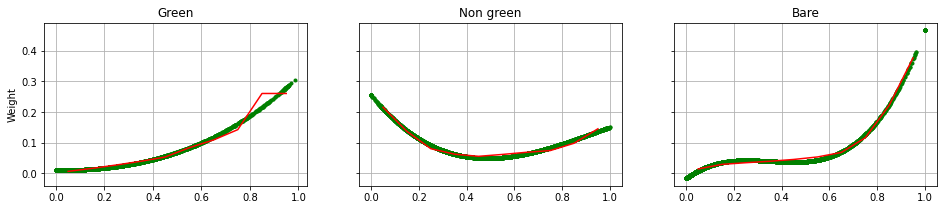

## Tune the model in Keras

In [ ]:

def histogramWeightedLoss(y_true, y_pred):

    yWeights = tf.transpose([
        tf.math.polyval([ 1.6816264,-1.7737647,0.57555956,-0.0163076 ], y_true[:,0]),
        tf.math.polyval([ 0.13610764,0.1719074,-0.00244915,0.01020859], y_true[:,1]),
        tf.math.polyval([-0.47778377,1.3296368,-0.9564697,0.25497934], y_true[:,2])
    ])
   
    unmixingError = K.mean(K.abs(y_true * yWeights - y_pred * yWeights),axis=-1)
    negativityError =  K.mean(-y_pred * K.cast(K.less(y_pred,0), K.floatx()),axis=1)
    sum2oneError =  0.005 * K.abs(K.sum(y_pred,axis=1)-1.0)

    loss = unmixingError + sum2oneError + negativityError 
    
    return loss



def build_model(hp):
    model = keras.Sequential([
    layers.Dense(units=hp.Choice('layer1',values=[32,64,128]), activation='relu',kernel_constraint=max_norm(hp.Choice('norm',values=[1,3,5])),input_shape=[len(train_dataset.keys())]),
    layers.Dense(units=hp.Choice('layer2',values=[32,64,128]), activation='relu', kernel_constraint=max_norm(hp.Choice('norm',values=[1,3,5]))),
    layers.Dense(units=hp.Choice('layer3',values=[32,64,128]), activation='relu',kernel_constraint=max_norm(hp.Choice('norm',values=[1,3,5]))),
    layers.Dense(3)
    ])
    optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate',values=[0.02,0.01,0.005, 0.002, 0.001]))
    model.compile(loss=histogramWeightedLoss,
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error']) #'huber_loss'
    return model


tuner = RandomSearch(
    build_model,
    objective='mean_squared_error',
    max_trials=1000,
    executions_per_trial=10,
    directory='modelTuning',
    project_name='fractionalCover2')

#tuner.search_space_summary()

tuner.search(np.asarray(train_dataset), np.asarray(train_labels),
             epochs=2000,validation_split=0.2,verbose=0,shuffle=True,batch_size=4096)


In [ ]:
tuner.results_summary()
model = tuner.get_best_models(num_models=1)[0]
print(model.summary())
print('Kernel Constraint:',model.get_layer('dense_1').kernel_constraint.max_value)
print('Learning Rate:',model.optimizer.get_config()['learning_rate'])

c1a2c291e8c338f96a346a8c76cc9d56
{'layer1': 256, 'norm': 5, 'layer2': 256, 'layer3': 256, 'learning_rate': 0.005}


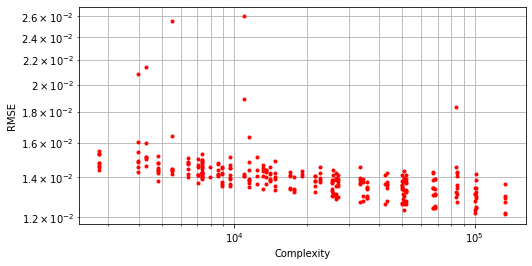

In [16]:
import glob
import json
rmse=[]
rmsev=[]
parameters=[]
trialID=[]
for trial in glob.glob('modelTuning/fractionalCover9/*/trial.json'):
    with open(trial) as summaryJson:
        summaryData = json.load(summaryJson)
    parameterCount = 8*summaryData['hyperparameters']['values']['layer1']+summaryData['hyperparameters']['values']['layer1']*summaryData['hyperparameters']['values']['layer2']+summaryData['hyperparameters']['values']['layer2']*summaryData['hyperparameters']['values']['layer3']+3*summaryData['hyperparameters']['values']['layer3']
    if parameterCount <1000000:
        rmse.append(summaryData['metrics']['metrics']['mean_squared_error']['observations'][0]['value'][0])
        rmsev.append(summaryData['metrics']['metrics']['val_mean_squared_error']['observations'][0]['value'][0])
        parameters.append(parameterCount)
        trialID.append(summaryData['trial_id'])
    
rmse=np.array(rmse)
rmsev=np.array(rmsev)
trialID=np.array(trialID)
parameters=np.array(parameters)
idx=np.argsort(rmsev)
rmse=rmse[idx]
rmsev=rmsev[idx]
trialID=trialID[idx]
parameters=parameters[idx]
print(trialID[0])
with open('modelTuning/fractionalCover9/trial_'+trialID[0]+'/trial.json') as summaryJson:
    print(json.load(summaryJson)['hyperparameters']['values'])

    
fig = plt.figure(figsize=(8,4))
plt.loglog(parameters,rmse,'r.')
plt.grid(True, which="both")
plt.xlabel('Complexity')
plt.ylabel('RMSE')

plt.savefig('rmse_complexity', bbox_inches='tight')

trialID

## Build the model in Keras

In [ ]:
with open('modelTuning/fractionalCover5/trial_'+trialID[3]+'/trial.json') as summaryJson:
    print(json.load(summaryJson)['hyperparameters']['values'])

In [ ]:

# Testing The Cost Function
def histogramWeightedLoss6Outputs(y_true, y_pred):

    yWeights = y_true[:,3:]
    yTrue = y_true[:,:3] * yWeights
    yPred = y_pred[:,:3] * yWeights
    loss = K.mean(K.abs(yTrue - yPred),axis=-1)

    
    return loss

def sum2One(y_true, y_pred):

    yWeights = tf.transpose([
    tf.math.polyval([ 1.6816264,-1.7737647,0.57555956,-0.0163076 ], y_true[:,0]),
    tf.math.polyval([ 0.13610764,0.1719074,-0.00244915,0.01020859], y_true[:,1]),
    tf.math.polyval([-0.47778377,1.3296368,-0.9564697,0.25497934], y_true[:,2])
    ])

    unmixingError = K.mean(K.square(y_true * yWeights - y_pred * yWeights),axis=-1)
    
    
    positivityError =  1.0 + K.sum(K.cast(K.greater(y_pred,1.05), K.floatx()),axis=1)
    negativityError =  K.max(-y_pred * K.cast(K.less(y_pred,-0.05), K.floatx()),axis=1)
    sum2oneError = K.abs(K.sum(y_pred,axis=1)-1.0)
    constraintError = sum2oneError  * positivityError * negativityError

    loss = unmixingError * 1.0 + constraintError * 0.005
    return negativityError


y_true = K.constant(np.array(full_labels))
y_pred = K.constant(np.array(full_labels)*-0.1)

K.eval(sum2One(y_true, y_pred)) # --> 1.0


In [11]:
def histogramWeightedLoss(y_true, y_pred):

    yWeights = tf.transpose([
        tf.math.polyval([ 1.6816264,-1.7737647,0.57555956,-0.0163076 ], y_true[:,0]),
        tf.math.polyval([ 0.13610764,0.1719074,-0.00244915,0.01020859], y_true[:,1]),
        tf.math.polyval([-0.47778377,1.3296368,-0.9564697,0.25497934], y_true[:,2])
    ])
   
    unmixingError = K.mean(K.abs(y_true * yWeights - y_pred * yWeights),axis=-1)
    negativityError =  K.mean(-y_pred * K.cast(K.less(y_pred,0), K.floatx()),axis=1)
    sum2oneError =  0.005 * K.abs(K.sum(y_pred,axis=1)-1.0)

    loss = unmixingError + sum2oneError + negativityError 
    
    return loss



model = keras.Sequential([
layers.Dense(256, activation='relu',kernel_constraint=max_norm(3),input_shape=[len(train_dataset.keys())]),
layers.Dense(64, activation='relu', kernel_constraint=max_norm(3)),
layers.Dense(256, activation='relu',kernel_constraint=max_norm(3)),
layers.Dense(3)
])

model.compile(loss=histogramWeightedLoss,
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            metrics=['mean_absolute_error', 'mean_squared_error']) #'huber_loss'

model.summary()

# Plot the model
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=False, )

# Setup Tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               1536      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_18 (Dense)             (None, 256)               16640     
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 771       
Total params: 35,395
Trainable params: 35,395
Non-trainable params: 0
_________________________________________________________________
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --host 0.0.0.0  --logdir logs

#watch -d -n 1 nvidia-smi

## Train the model
Note we set up a couple of callbacks to display progress and stop after a while

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=500)

# Fit the Model np.hstack((full_labels,sampleWeights))
history = model.fit(np.array(full_dataset), np.array(full_labels),
                    epochs=10000,
                    validation_split = 0.5,
                    verbose=0,
                    shuffle=True,
                    batch_size=4096,
                    callbacks=[early_stop,PrintDot(),tensorboard_callback])
print('\n')

# Save the model
modelName = 'fcModel_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'.hd5'
model.save(modelName,save_format='h5')
# Save a TFLite version
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open(modelName.replace('hd5','tflite'), "wb").write(tflite_model)

print('Saved: ',modelName)




#loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)


# Display the training history
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('RMSE')
  plt.plot(hist['epoch'], np.sqrt(hist['mean_squared_error']),label='Train Error')
  plt.plot(hist['epoch'], np.sqrt(hist['val_mean_squared_error']),label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

## Plot the final predictions and sum to one

In [73]:
np.percentile(predBareCover,1)

0.0017476189136505123

In [ ]:
# Predict!
#test_predictions = model.predict(normed_test_data)
allLabels = train_labels
allPredictions = model.predict(train_dataset)

# Get the values
totalPVCover=allLabels['pv']
totalNPVCover=allLabels['npv']
totalBareCover=allLabels['bare']
predNongreenCover=allPredictions[:,2]
predGreenCover=allPredictions[:,1]
predBareCover=allPredictions[:,0]
totalSum = predNongreenCover+predGreenCover+predBareCover

# Print some RMSE values
print( "Green RMSE = %f" % np.sqrt(np.mean((totalPVCover-predGreenCover)**2)))
print( "Non Green RMSE = %f" % np.sqrt(np.mean((totalNPVCover-predNongreenCover)**2)))
print( "Bare RMSE = %f" % np.sqrt(np.mean((totalBareCover-predBareCover)**2)))
print( "Min Bare = %f" % np.percentile(predBareCover,1))
print( "Min Green = %f" % np.percentile(predGreenCover,1))
print( "Min NonGreen = %f" % np.percentile(predNongreenCover,1))


# Setup the sum to one histogram
fig = plt.figure(figsize=(8,8))
plt.hist(totalSum, bins=100)
plt.title('SumToOne', fontsize=16)
plt.grid(True)
plt.savefig('fcSum2one.png', bbox_inches='tight')

# Initialise the 1 row 3 column plot for each fraction
f, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(16,5),sharey=True)
# Plot the three fractions
ax1.plot(totalPVCover,predGreenCover, 'go',alpha=0.1,markeredgewidth=0.0)
ax2.plot(totalNPVCover,predNongreenCover, 'bo',alpha=0.1,markeredgewidth=0.0)
ax3.plot(totalBareCover,predBareCover, 'ro',alpha=0.1,markeredgewidth=0.0)
# Grids
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
# Titles and Labels
ax1.set_title('Green')
ax2.set_title('Non green')
ax3.set_title('Bare')
ax1.set_xlabel('Observed')
ax2.set_xlabel('Observed')
ax3.set_xlabel('Observed')
ax1.set_ylabel('Predicted')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
f.savefig('fcCalibration.png', bbox_inches='tight')






## Run the model on the latest Seasonal Image

In [14]:
modelName

'fcModel_202005250053.hd5'

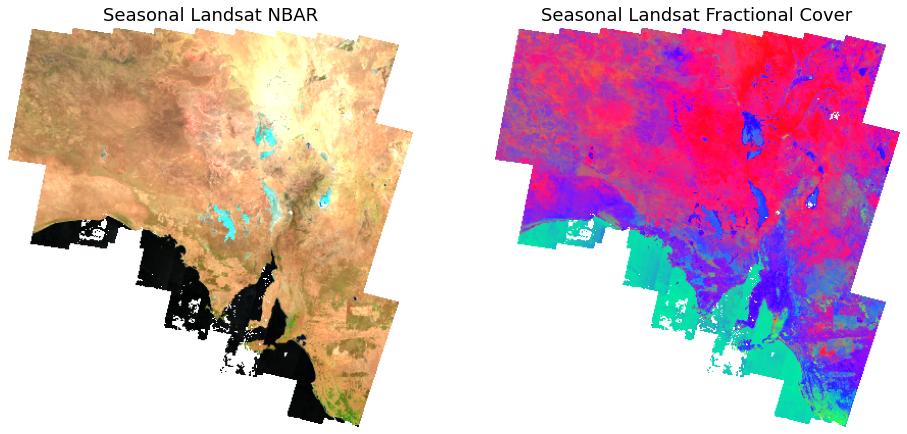

In [36]:
from __future__ import absolute_import, division, print_function, unicode_literals

import rasterio
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# The unmixing model
def unmixfc(nbar, fcModel):
    # Get the shape of the input array
    inshape = nbar.shape
    # Flatten and scale reflectance
    nbar = np.reshape(nbar,(inshape[0],-1)) / 10000.0

    # Convert Landsat 8 if required
    nbar = np.transpose(np.transpose(nbar) * 
                        np.array([0.97470, 0.99779, 1.00446, 0.98906, 0.99467, 1.02551]) + 
                        np.array([0.00041, 0.00289, 0.00274, 0.00004, 0.00256, -0.00327]))

    # Convert Sentinel 2 if required
    #nbar = np.transpose(np.transpose(nbar[[0,1,2,3,8,9]]) * 
    #                   np.array([0.9551, 1.0582, 0.9871, 1.0187, 0.9528, 0.9688]) + 
    #                  np.array([-0.0022, 0.0031, 0.0064, 0.012, 0.0079, -0.0042]))

    # Drop the Blue band. Blue is yukky
    #ndvi = (nbar[3]-nbar[2])/(nbar[3]+nbar[2] + np.finfo('float32').eps)
    #refData = np.transpose(np.append(nbar[1:],[ndvi],axis=0))
    refData = np.transpose(nbar[1:])

    # Run the prediction
    fcLayers = np.clip(fcModel.predict(refData)[:,0:3].T,0,2)
    fcLayerSum = fcLayers.sum(axis=0) + np.finfo('float32').eps
    # Clip Output
    outputFC = np.round(100 * fcLayers/fcLayerSum, 0)
    # Correct noData
    outputFC[:,nbar[0] < 0.001] = 255
    outputFC[:,nbar[0] > 0.999] = 255
    # Reshape the FC Output
    return np.reshape(outputFC,(3,inshape[1],inshape[2])).astype(np.uint8),fcLayers


# Connect to the seasonal surface reflectance
dataPath = '/vsicurl/http://qld.auscover.org.au/public/data/landsat/surface_reflectance/qld/l8olre_qld_m201906201908_dbia2.tif'
dataPath = '/vsicurl/https://data.tern.org.au/rs/public/data/landsat/surface_reflectance/sa/l8olre_sa_m201412201502_dbia2.tif'
# Open the data set
refDataSet = rasterio.open(dataPath)
# Read in the imagery at an overview level
overviewLevel = 128
refData = np.ma.masked_equal(refDataSet.read(
    out_shape=(refDataSet.count,
               int(refDataSet.height / overviewLevel),
               int(refDataSet.width / overviewLevel))),
               refDataSet.nodatavals[0])

# Run the prediction
fcModel = tf.keras.models.load_model(modelName,compile=False)
fcImage,fcLayers = unmixfc(refData,fcModel)

# Plot the images
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,16),sharey=True)
# Plot the three fractions
ax1.imshow(
    np.rollaxis(
        np.clip(refData[[4,3,2]] / 4000.0 * 255.0, 0, 255)
        .astype('uint8')
        ,0,3)
    , aspect=1)
ax1.set_title('Seasonal Landsat NBAR', fontsize=18)
ax1.axis('off');

ax2.imshow(
    np.rollaxis(
        np.clip(fcImage / 100.0 * 400.0, 0, 255)
        .astype('uint8')
        ,0,3)
    , aspect=1)
ax2.set_title('Seasonal Landsat Fractional Cover', fontsize=18)
ax2.axis('off');

f.savefig('fcPredictions.png', bbox_inches='tight')


In [ ]:
fig = plt.figure(figsize=(8,8))

histData = np.reshape(fcLayers,-1)
plt.hist(histData[histData<250], bins=100,log=True);
plt.title('Fraction Retrieval Histogram', fontsize=16)
plt.grid(True)
plt.savefig('fcHistogram.png', bbox_inches='tight')

## Export to tensorflow.js
...only if you want to run in javascript

In [ ]:
#!pip install tensorflowjs
!tensorflowjs_converter --input_format keras fc.hd5 tfjs


In [ ]:
'fcModel_'+datetime.datetime.now().strftime("%Y%m%d%H%M")+'.hd5'

### Field Data Plotting

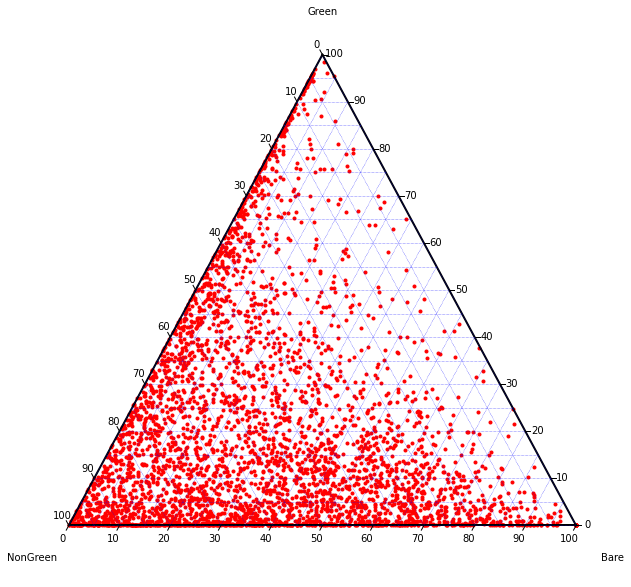

In [27]:
import ternary

### Scatter Plot
scale = 100
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(10,10)
#tax.set_title("Scatter Plot", fontsize=20)
tax.boundary(linewidth=2.0)
tax.gridlines(multiple=5, color="blue")
# Plot a few different styles with a legend
tax.scatter(np.array(train_labels)*100, marker='.', color='red')
tax.ticks(axis='lbr', linewidth=1, multiple=10)
tax.right_corner_label("Bare", fontsize=10)
tax.top_corner_label("Green", fontsize=10)
tax.left_corner_label("NonGreen", fontsize=10)
tax.get_axes().axis('off')
tax.clear_matplotlib_ticks()
tax.show()

In [35]:
# Save a TFLite version
import tensorflow as tf
modelName='fcModel_256x64x256.hd5'
model = tf.keras.models.load_model(modelName,compile=False)
td = np.array(train_dataset).astype(np.float32)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_gen():
  for i in range(len(td)):
    # Get sample input data as a numpy array in a method of your choosing.
    yield [td[i,np.newaxis]]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()

open(modelName.replace('hd5','8bit.tflite'), "wb").write(tflite_quant_model)


39696